Expected number of basis functions: 6
Baseline has 6 basis functions
Iteration 0: Loss = 52.6662
Iteration 10: Loss = 51.8217
Iteration 20: Loss = 51.1313
Iteration 30: Loss = 50.5665
Iteration 40: Loss = 50.0939
Iteration 50: Loss = 49.6894
Iteration 60: Loss = 49.3420
Iteration 70: Loss = 49.0449
Iteration 80: Loss = 48.7919
Iteration 90: Loss = 48.5770


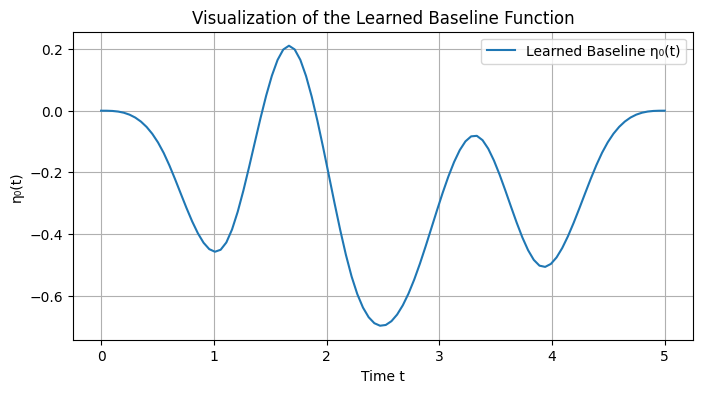

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

########################
# 1. B-Spline Basis Evaluation (Cox–de Boor Recursion)
########################

def bspline_basis(t, knots, degree):
    """
    Compute the B-spline basis functions for a set of input values t,
    given a knot vector and degree using the Cox–de Boor recursion.
    
    t: Tensor of shape [N] (values at which to evaluate the basis).
    knots: 1D tensor of knot locations (must be non-decreasing).
    degree: Degree of the spline.
    
    Returns: Tensor of shape [N, n_basis], where n_basis = len(knots) - degree - 1.
    """
    # Ensure t is of shape [N, 1]
    t = t.unsqueeze(1)  # shape [N, 1]
    M = knots.shape[0]
    n_basis = M - degree - 1  # number of basis functions
    N = t.shape[0]
    
    # Initialize degree 0 basis functions:
    # B_i,0(t) = 1 if knots[i] <= t < knots[i+1], else 0.
    # For the right-most knot, include t==knots[-1].
    B = torch.zeros(N, M-1, device=t.device)
    for i in range(M - 1):
        # For last basis function, include t==knots[-1]
        if i == M - 2:
            B[:, i] = ((t >= knots[i]) & (t <= knots[i+1])).float().squeeze()
        else:
            B[:, i] = ((t >= knots[i]) & (t < knots[i+1])).float().squeeze()
    
    # Recursion for d=1,...,degree:
    for d in range(1, degree + 1):
        new_B = torch.zeros(N, M-d-1, device=t.device)
        for i in range(M - d - 1):
            # Compute first term:
            denom1 = knots[i + d] - knots[i]
            # Avoid division by zero:
            denom1 = denom1 if denom1 > 0 else 1e-8
            term1 = ((t - knots[i]) / denom1) * B[:, i:i+1]
            
            # Compute second term:
            denom2 = knots[i + d + 1] - knots[i + 1]
            denom2 = denom2 if denom2 > 0 else 1e-8
            term2 = ((knots[i + d + 1] - t) / denom2) * B[:, i+1:i+2]
            
            new_B[:, i] = (term1 + term2).squeeze()
        B = new_B  # shape [N, M - d - 1]
    
    return B  # final shape: [N, n_basis]

########################
# 2. BSplineFunction for Univariate Functions
########################

class BSplineFunction(nn.Module):
    """
    Evaluates a univariate B-spline function f(x) = sum_i coef_i * B_i(x)
    using a given knot vector and degree.
    """
    def __init__(self, knots, degree=3):
        super().__init__()
        self.knots = knots
        self.degree = degree
        n_basis = len(knots) - degree - 1
        # Initialize coefficients; you can adjust initialization scale if needed.
        self.coefs = nn.Parameter(torch.zeros(n_basis))
    
    def forward(self, x):
        # x: shape [batch_size]
        B = bspline_basis(x, self.knots, self.degree)  # shape [batch_size, n_basis]
        return torch.matmul(B, self.coefs)

########################
# 3. BSplineBaseline for η₀(t)
########################

class BSplineBaseline(nn.Module):
    def __init__(self, knots, degree=3):
        """
        knots: 1D tensor of knot locations for the baseline (must be non-decreasing).
        degree: Degree of the spline.
        """
        super().__init__()
        self.knots = knots
        self.degree = degree
        n_basis = len(knots) - degree - 1
        print(f"Baseline has {n_basis} basis functions")  # Debugging info
        self.coefs = nn.Parameter(torch.zeros(n_basis))
    
    def forward(self, t):
        # t: Tensor of shape [batch_size]
        B = bspline_basis(t, self.knots, self.degree)  # shape [batch_size, n_basis]
        eta_t = torch.matmul(B, self.coefs)
        return eta_t

########################
# 4. UnivariateKAN Using Proper B-Spline
########################

class UnivariateKAN(nn.Module):
    """
    Implements a univariate transformation using a proper B-spline.
    """
    def __init__(self, num_knots=10, knot_range=(0.0, 1.0), degree=3):
        super().__init__()
        self.num_knots = num_knots
        self.degree = degree
        # Create knot vector: must have num_knots elements
        total_knots = num_knots + 2 * degree
        # We need more knots at endpoints to account for degree
        self.register_buffer('knots', torch.linspace(knot_range[0], knot_range[1], steps=total_knots))
        self.bspline_func = BSplineFunction(self.knots, degree)
    
    def forward(self, x):
        # x: Tensor of shape [batch_size]
        return self.bspline_func(x)

########################
# 5. KANBlock: Sum of Univariate KAN Edges
########################

class KANBlock(nn.Module):
    """
    Transforms an input vector (dimension in_dim) into an output vector (dimension out_dim)
    by summing univariate transformations on each input.
    """
    def __init__(self, in_dim, out_dim, num_knots=10, knot_range=(0.0, 1.0), degree=3):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Create one UnivariateKAN for each edge (total out_dim * in_dim edges)
        self.edges = nn.ModuleList([
            UnivariateKAN(num_knots=num_knots, knot_range=knot_range, degree=degree)
            for _ in range(out_dim * in_dim)
        ])
    
    def forward(self, z_in):
        # z_in: shape [batch_size, in_dim]
        batch_size = z_in.shape[0]
        z_out = torch.zeros(batch_size, self.out_dim, device=z_in.device)
        idx = 0
        for u in range(self.out_dim):
            sum_u = 0
            for v in range(self.in_dim):
                phi_uv = self.edges[idx]
                sum_u = sum_u + phi_uv(z_in[:, v])
                idx += 1
            z_out[:, u] = sum_u
        return z_out

########################
# 6. KANModel: Stack KANBlocks to Build f(x)
########################

class KANModel(nn.Module):
    """
    A simple two-layer KAN to map d_x -> hidden -> 1.
    """
    def __init__(self, d_x, hidden_dim, num_knots=10, knot_range=(0.0, 1.0), degree=3):
        super().__init__()
        self.layer1 = KANBlock(d_x, hidden_dim, num_knots, knot_range, degree)
        self.layer2 = KANBlock(hidden_dim, 1, num_knots, knot_range, degree)
    
    def forward(self, x):
        # x: shape [batch_size, d_x]
        z = self.layer1(x)
        z = self.layer2(z)
        return z.squeeze(-1)

########################
# 7. Inhomogeneous Poisson Process Model
########################

class InhomPoissonModel(nn.Module):
    def __init__(self, baseline_knots, baseline_degree, d_x, hidden_dim,
                 kan_num_knots=10, kan_knot_range=(0.0, 1.0), kan_degree=3):
        """
        baseline_knots: 1D tensor of knot locations for the baseline.
        baseline_degree: degree for baseline B-spline.
        d_x: dimension of covariates.
        hidden_dim: hidden dimension in the KAN.
        kan_num_knots, kan_knot_range, kan_degree: parameters for the KAN edges.
        """
        super().__init__()
        self.baseline = BSplineBaseline(baseline_knots, degree=baseline_degree)
        self.fKAN = KANModel(d_x, hidden_dim, num_knots=kan_num_knots,
                             knot_range=kan_knot_range, degree=kan_degree)
    
    def intensity_at_time(self, t, x):
        """
        Computes λ(t) = exp{ η₀(t) + f(x) }.
        t: Tensor of shape [batch_size]
        x: Tensor of shape [batch_size, d_x]
        """
        baseline_val = self.baseline(t)
        f_val = self.fKAN(x)
        log_lambda = baseline_val + f_val
        return torch.exp(log_lambda)

########################
# 8. Log-Likelihood & Training Loop
########################

def compute_loglik(model, batch_events, batch_censoring, n_integration_pts=10):
    """
    Compute the log-likelihood over a batch.
    batch_events: list (length = num_subjects) of lists of events.
      Each event is a tuple (t_event, x_event) where:
         t_event: scalar event time (float)
         x_event: Tensor of shape [d_x] (covariate vector at event time)
    batch_censoring: list (length = num_subjects) of tuples (c_i, x_i)
      where c_i is the censoring time (float) and x_i is the covariate vector
      (assumed constant for integration; shape [d_x])
    """
    log_sum = 0.0
    for i, evts in enumerate(batch_events):
        # Event term: sum_{j=1}^{n_i} [η₀(t_{ij}) + f(x_{ij})]
        if len(evts) > 0:
            tvals = torch.tensor([e[0] for e in evts], dtype=torch.float32,
                                 device=model.baseline.coefs.device)
            xvals = torch.stack([e[1] for e in evts], dim=0)  # shape [n_i, d_x]
            log_lam = model.baseline(tvals) + model.fKAN(xvals)
            log_sum_events = torch.sum(log_lam)
        else:
            log_sum_events = 0.0

        # Integral term: approximate ∫₀^(c_i) exp{η₀(t) + f(x_i)} dt
        cend = batch_censoring[i][0]
        x_const = batch_censoring[i][1]  # constant covariates
        times_grid = torch.linspace(0.0, cend, steps=n_integration_pts,
                                    device=model.baseline.coefs.device)
        x_grid = x_const.unsqueeze(0).repeat(n_integration_pts, 1)
        lam_vals = model.intensity_at_time(times_grid, x_grid)
        # Use trapezoidal rule for integration:
        integral_approx = torch.trapz(lam_vals, times_grid)
        log_sum_i = log_sum_events - integral_approx
        log_sum = log_sum + log_sum_i
    return log_sum

def generate_dummy_data(num_subjects=5, d_x=3):
    """
    Generate dummy dataset:
      - For each subject, a random censoring time c_i in [1,5]
      - A random number (0 to 3) of event times uniformly in [0, c_i]
      - Covariates are random vectors in [0,1]^d_x.
    Returns:
      batch_events: list of lists of (t_event, x_event)
      batch_censoring: list of (c_i, x_i)
    """
    batch_events = []
    batch_censoring = []
    for _ in range(num_subjects):
        c_i = torch.rand(1).item() * 4 + 1.0  # censoring between 1 and 5
        n_events = torch.randint(0, 4, (1,)).item()
        if n_events > 0:
            t_events = torch.sort(torch.rand(n_events) * c_i)[0]
            events = [(t.item(), torch.rand(d_x)) for t in t_events]
        else:
            events = []
        x_i = torch.rand(d_x)
        batch_events.append(events)
        batch_censoring.append((c_i, x_i))
    return batch_events, batch_censoring

########################
# 9. Main Training Loop with Visualization
########################

def main():
    # Parameters for the baseline B-spline:
    baseline_degree = 3
    n_knots = 10  # Total number of knots for the baseline
    baseline_knots = torch.linspace(0.0, 5.0, steps=n_knots)
    
    # Print expected number of basis functions
    expected_basis = len(baseline_knots) - baseline_degree - 1
    print(f"Expected number of basis functions: {expected_basis}")
    
    # KAN settings:
    d_x = 3
    hidden_dim = 10
    kan_num_knots = 8  # Adjusted for proper basis dimension
    kan_knot_range = (0.0, 1.0)
    kan_degree = 3
    
    # Create the model
    model = InhomPoissonModel(baseline_knots, baseline_degree, d_x, hidden_dim,
                              kan_num_knots, kan_knot_range, kan_degree)
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Generate dummy data
    batch_events, batch_censoring = generate_dummy_data(num_subjects=20, d_x=d_x)
    
    num_iters = 100
    for iter in range(num_iters):
        optimizer.zero_grad()
        loglik = compute_loglik(model, batch_events, batch_censoring, n_integration_pts=20)
        loss = -loglik
        loss.backward()
        optimizer.step()
        
        if iter % 10 == 0:
            print(f"Iteration {iter}: Loss = {loss.item():.4f}")
    
    # After training, visualize the learned baseline function η₀(t)
    model.eval()
    t_grid = torch.linspace(0.0, 5.0, steps=100)
    with torch.no_grad():
        eta_values = model.baseline(t_grid)
    
    plt.figure(figsize=(8, 4))
    plt.plot(t_grid.cpu().numpy(), eta_values.cpu().numpy(), label='Learned Baseline η₀(t)')
    plt.xlabel('Time t')
    plt.ylabel('η₀(t)')
    plt.title('Visualization of the Learned Baseline Function')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [6]:
torch.matmul(B, self.coefs.view(-1))


NameError: name 'B' is not defined